# Increasing Profit using Customer Trends
By ...

## Introduction
In this blog, we will be using historical transaction data to build a recommendation and purchase prediction model. This model can be used to assist the retail salespersons in increasing profits by providing insight into what a customer may potentially purchase and at what price. This model will be built using the TensorFlow library and deployed using Google’s Vertex AI platform that has been recently released on September 15, 2021.

## Business Understanding

### Black Friday Sales
Black Friday is a colloquial term for the Friday following Thanksgiving in the United States and can be seen as the start of the Christmas shopping season. Retail stores aggressively promote sales at discounted prices. This season is crucial for the economy and retails as many consumers hold out for these sales due to the large discounts and great offers. For retailers, this is an opportunity to move overstocked items at the lowest possible process and move season items off the shelf.

On Black Friday 2021, US consumers spent  \$8.92 billion at online sales for goods after Thanksgiving. This only just falls short of the previous years record-setting $9.03 billion according to Adobe.

Due to the growing popularity of Black Friday Sales, Retailers spent a significant amount of the year and resources planning their sales to maximise profits.

### Recommendation Models
A recommender models seek to predict the rating or preference of a given item. They can be used accross music plateforms, social media newsfeeds, streaming services etc. These models work by finding patterns in the consumer behavior data which c

## Understanding the Data
To build our model we will be using the Black Friday Sales Dataset provided by ___. This dataset has been used to host a competition where participants try to predict the customer spending habits of “ABC Private Limited'', specifically total purchase amount for a given product over the course of a month. They have shared purchase summary of various customers for selected high volume products from last month. The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

This dataset has two files: train.csv and test.csv. As we are building a recommendation system, the test file is not necessary.

Using Python, Pandas, and some visualisation libraries such as seaborn, which is built ontop of MatPlotLib,  we are able to explore the data and extract some new trends. 


In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

df = pd.read_csv('datasets/train_black_friday.csv')
df.head()

2.7.0


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


### Features
The dataset is stored in a comma-seperated vales file (CSV). We will load it in and look at both the data types of each column and the statistcial information.

The dataset contains 550,068 entries and 12 features. These features are:


| Column Name | Description | Datatype | 
|-------------|-------------|----------|
| User_ID | Unique ID of the customer| int64 |
| Product ID | Unique ID of the product | object |
| Gender | Sex of the customer | object |
| Age | Age of the customer | object |
| Occupation | Occupation code of the customer | int64 |
| City_Category | City of the customer | object |
| Stay_In_Current_City_Years | Number of years the customer has lived in the city | object | 
| Marital_Status | Maritial status of the customer | int64 |
| Product_Category_1 | Category of product | int64 |
| Product_Category_2 | Category of product | float64 |
| Product_Category_3 | Category of product | float64 |
| Purchase | Total amount spent on a particualar product over the past month | int64 |

At first glance you will see notice that the purchase price for a particular Product_ID varies between User_IDs. It is important to note that the Purchase feature represents the **total amount spent over the last month**. 

*Occupation*, *City_Category*, *Marital_Status*, *Product_Category_1*, *Product_Category_2*, and *Product_Category_3* have been masked.

This information can be found using pandas' ``` df.info() ``` and ``` df.describe() ```.Additional information such as statistical information and feature datatypes can be discovered using the following code:

In [6]:
# Datatype info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [7]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


*Product_Category_2* and *Product_Category_3* both are missing data. There are a number of methods that can apply to missing data. These are:
- Ignore the missing values. Missing values under 10% can generally be ignored, except when the data is dependant on the missing information.
- Drop the missing values.
- Drop the feature. If the number of missing values in a feature is very high then the feature should be left out of the analysis. Generally anymore than 5% of the data is missing from a feature, then that feature should be left out.
- Compute a value. The value can be imputed by the mean/mode/median. Other methods include regression techniques and K-Nearest Neighbour Imputation. 

Since these are used for categorising the *Product_ID* they are not missing at random. 

Out of the 550,068 records, *Product_Category_2* has 376,430 non-null records and *Product_Category_3* has 166,821 records that are not null. This is ~31.5% and ~70% of data points missing. *Product_Category_3* should be dropped however *Product_Category_2* should be kept due to being a dependant variable.

Below various features will be plotted to give a better understanding of their distributions.

<AxesSubplot:xlabel='Purchase', ylabel='Density'>

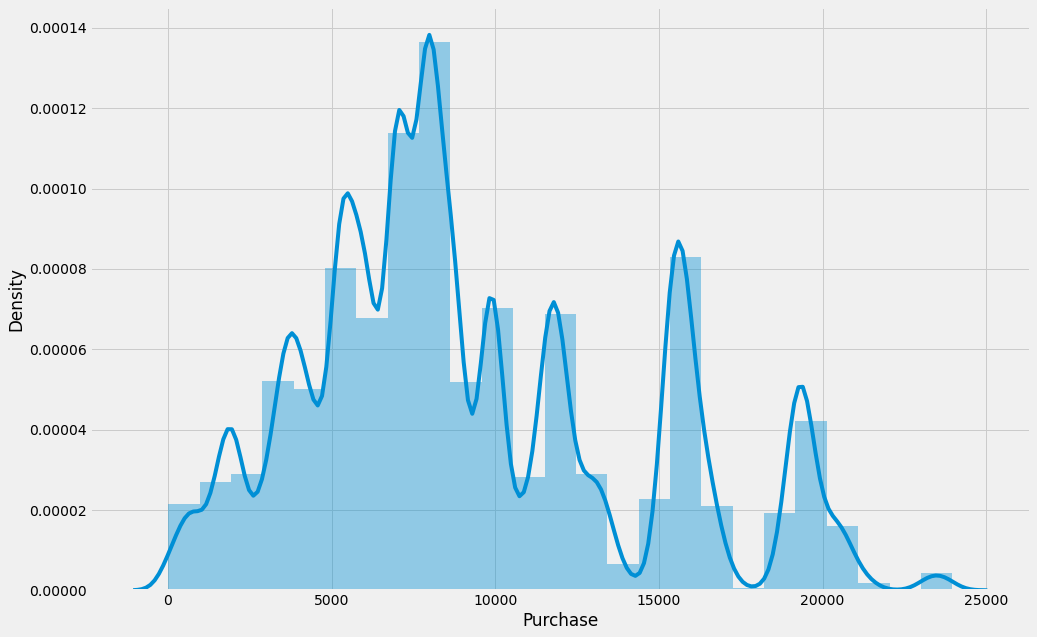

In [8]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,10))
sns.distplot(df['Purchase'], bins=25)

The *Purchase* feature show 3 normal distributions around ~\$9000, \$16,000 and \$19,000. This suggestions that their are potentially three types of customers profiles within the dataset.

<AxesSubplot:xlabel='Gender', ylabel='count'>

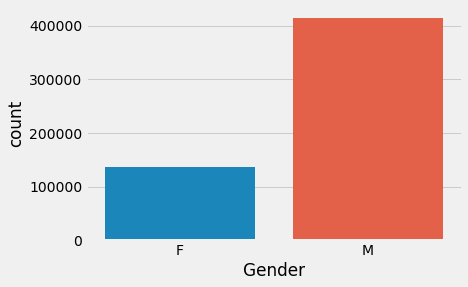

In [9]:
# distribution of numeric variables
sns.countplot(df['Gender'])

Depending on the context, gender should be carefully considered as this dataset only considers binary genders. Due to the context of the company and product details being masked, this feature has been left in as it may be relevent.

While this graph can be interpre shows males representing the majority of purchases it can be easily missunderstood. We must remember that the *Purchase* feature represents the total spent over the last month on a **single** product. This graph shows that males purchase a larger variety of products, however does not represent the amount each gender spends.

In [10]:
gender_df = df.groupby(["Gender"]).sum()
gender_df

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
Gender,,,,,,,
F,136234060927,915426,56988,776517,916139.0,468179.0,1186232642
M,415500008355,3527312,168349,2196199,2788809.0,1645150.0,3909580100


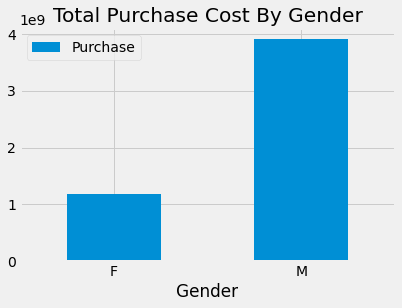

In [11]:
ax = gender_df.plot.bar(y='Purchase', rot=0, title='Total Purchase Cost By Gender')

The above plot shows the total purchase cost by gender. The ratio of purchase cost between genders is ~30.34%.

<AxesSubplot:xlabel='Age', ylabel='count'>

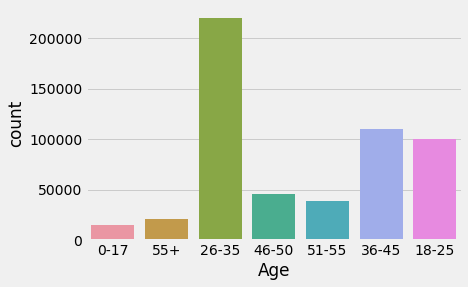

In [12]:
sns.countplot(df['Age'])

The target age shows a normal distribution centering around 26-35 years old.

<AxesSubplot:xlabel='Marital_Status', ylabel='count'>

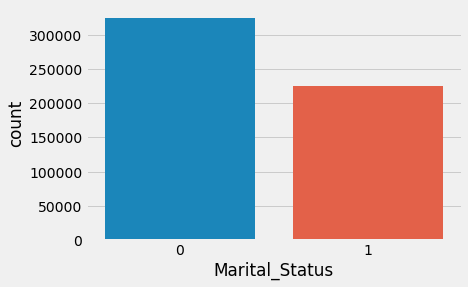

In [13]:
sns.countplot(df['Marital_Status'])

It is assumed that 0 represents 'single' while '1' represents married.

<AxesSubplot:xlabel='Occupation', ylabel='count'>

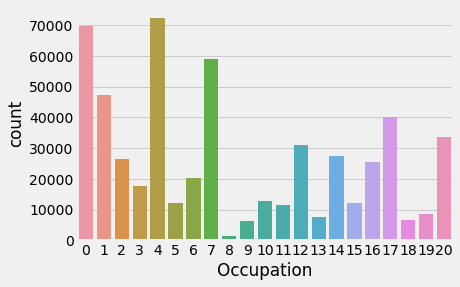

In [14]:
sns.countplot(df['Occupation'])

<AxesSubplot:xlabel='Product_Category_1', ylabel='count'>

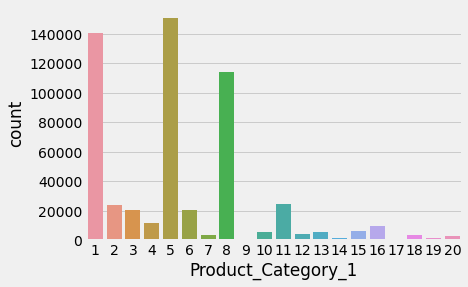

In [15]:
sns.countplot(df['Product_Category_1'])

<AxesSubplot:xlabel='Product_Category_2', ylabel='count'>

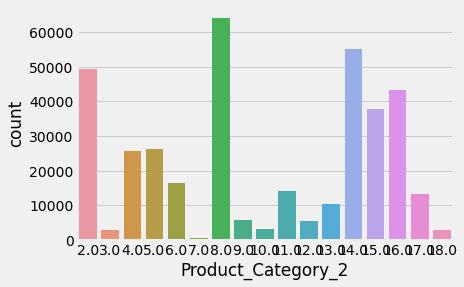

In [16]:
sns.countplot(df['Product_Category_2'])

<AxesSubplot:xlabel='Product_Category_3', ylabel='count'>

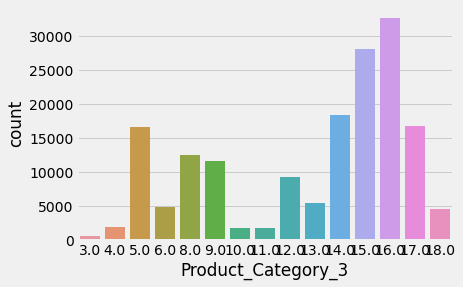

In [17]:
sns.countplot(df['Product_Category_3'])

<AxesSubplot:xlabel='City_Category', ylabel='count'>

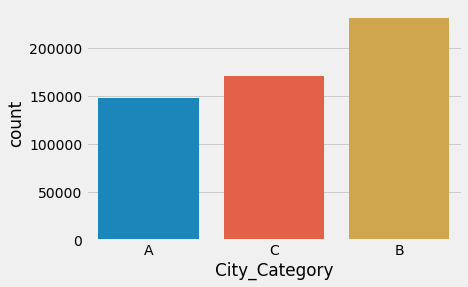

In [18]:
sns.countplot(df['City_Category'])

The product and city categories have been masked so little information can be interpreted from the graphs. It is possible that there are different demographics in each city.

<AxesSubplot:xlabel='Stay_In_Current_City_Years', ylabel='count'>

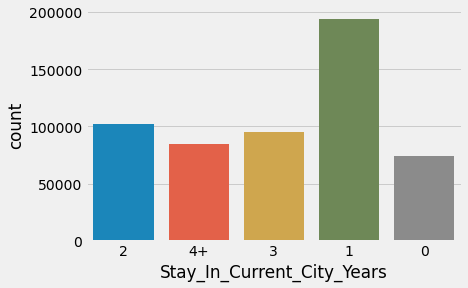

In [19]:
sns.countplot(df['Stay_In_Current_City_Years'])

# Preprocessing Data

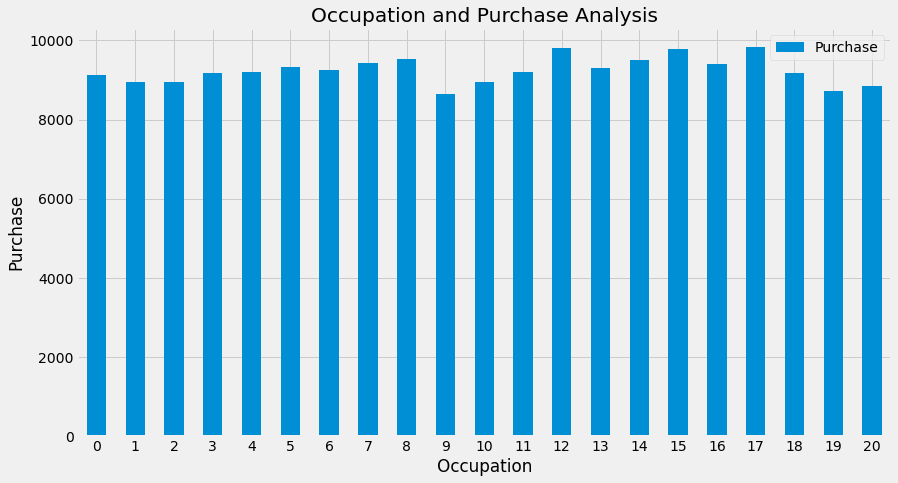

In [20]:
# Bivariate Analysis
occupation_plot = df.pivot_table(index='Occupation',values='Purchase', aggfunc=np.mean)
occupation_plot.plot(kind='bar', figsize=(13, 7))
plt.xlabel('Occupation')
plt.ylabel('Purchase')
plt.title('Occupation and Purchase Analysis')
plt.xticks(rotation=0)
plt.show()

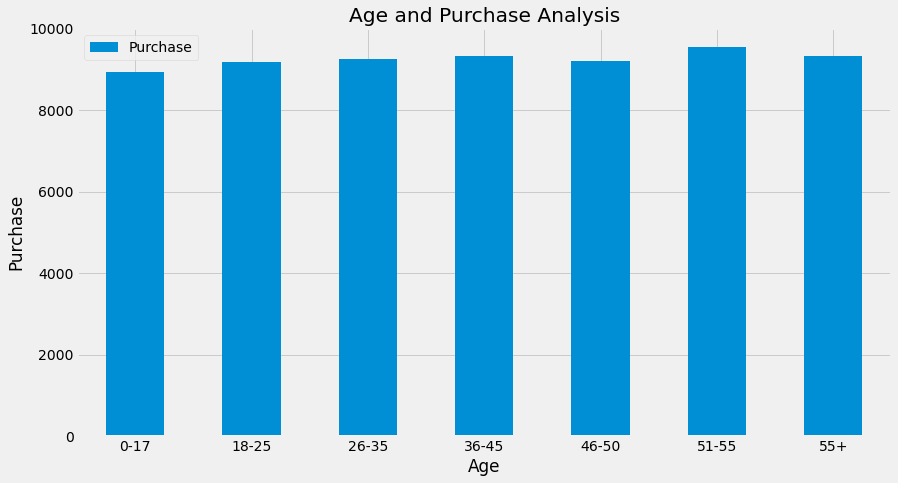

In [21]:
age_plot = df.pivot_table(index='Age',values='Purchase', aggfunc=np.mean)
age_plot.plot(kind='bar', figsize=(13, 7))
plt.xlabel('Age')
plt.ylabel('Purchase')
plt.title('Age and Purchase Analysis')
plt.xticks(rotation=0)
plt.show()

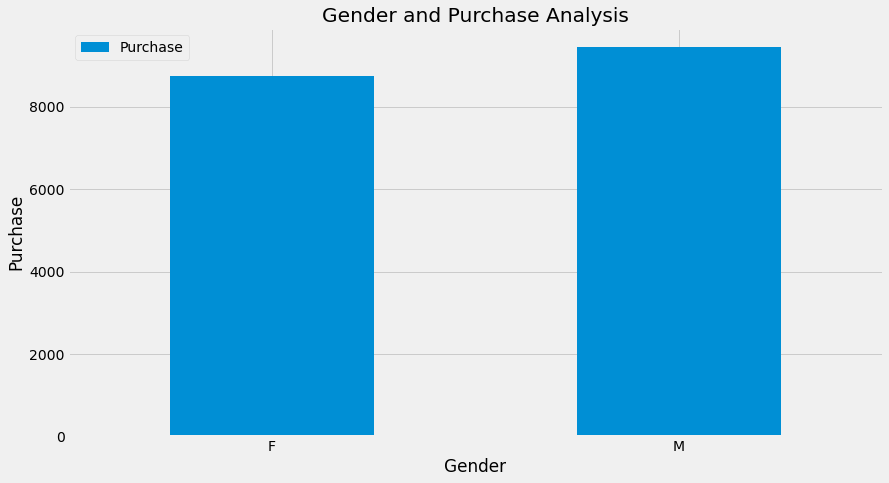

In [22]:
gender_plot = df.pivot_table(index='Gender',values='Purchase', aggfunc=np.mean)
gender_plot.plot(kind='bar', figsize=(13, 7))
plt.xlabel('Gender')
plt.ylabel('Purchase')
plt.title('Gender and Purchase Analysis')
plt.xticks(rotation=0)
plt.show()

# Preprocessing

In [23]:
# Check for null values
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [24]:
#df['Product_Category_2'] = df['Product_Category_2'].fillna(-2.0).astype('float32')
#df['Product_Category_3'] = df['Product_Category_3'].fillna(-2.0).astype('float32')

In [25]:
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [26]:
# Encoding values using dict
#gender_dict = {'F': 0, 'M': 1}
#df['Gender'] = df['Gender'].apply(lambda x: gender_dict[x])
#df.head()

In [27]:
# To imporve the metric use one-hot encoding
# label encoding 
cols = ['Product_ID', 'Age', 'City_Category', 'Stay_In_Current_City_Years']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cols:
  df[col] = le.fit_transform(df[col])

df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,672,F,0,10,0,2,0,3,NaN,NaN,8370
1,1000001,2376,F,0,10,0,2,0,1,6.0,14.0,15200
2,1000001,852,F,0,10,0,2,0,12,NaN,NaN,1422
3,1000001,828,F,0,10,0,2,0,12,14.0,NaN,1057
4,1000002,2734,M,6,16,2,4,0,8,NaN,NaN,7969


## Correlation matrix

<AxesSubplot:>

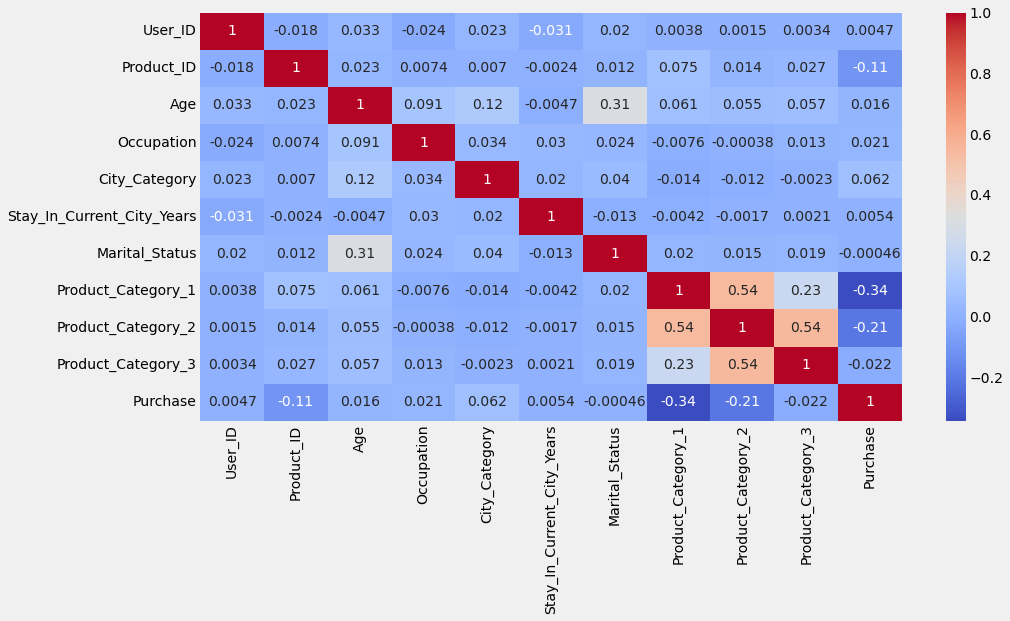

In [28]:
corr = df.corr()
plt.figure(figsize=(14, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm')

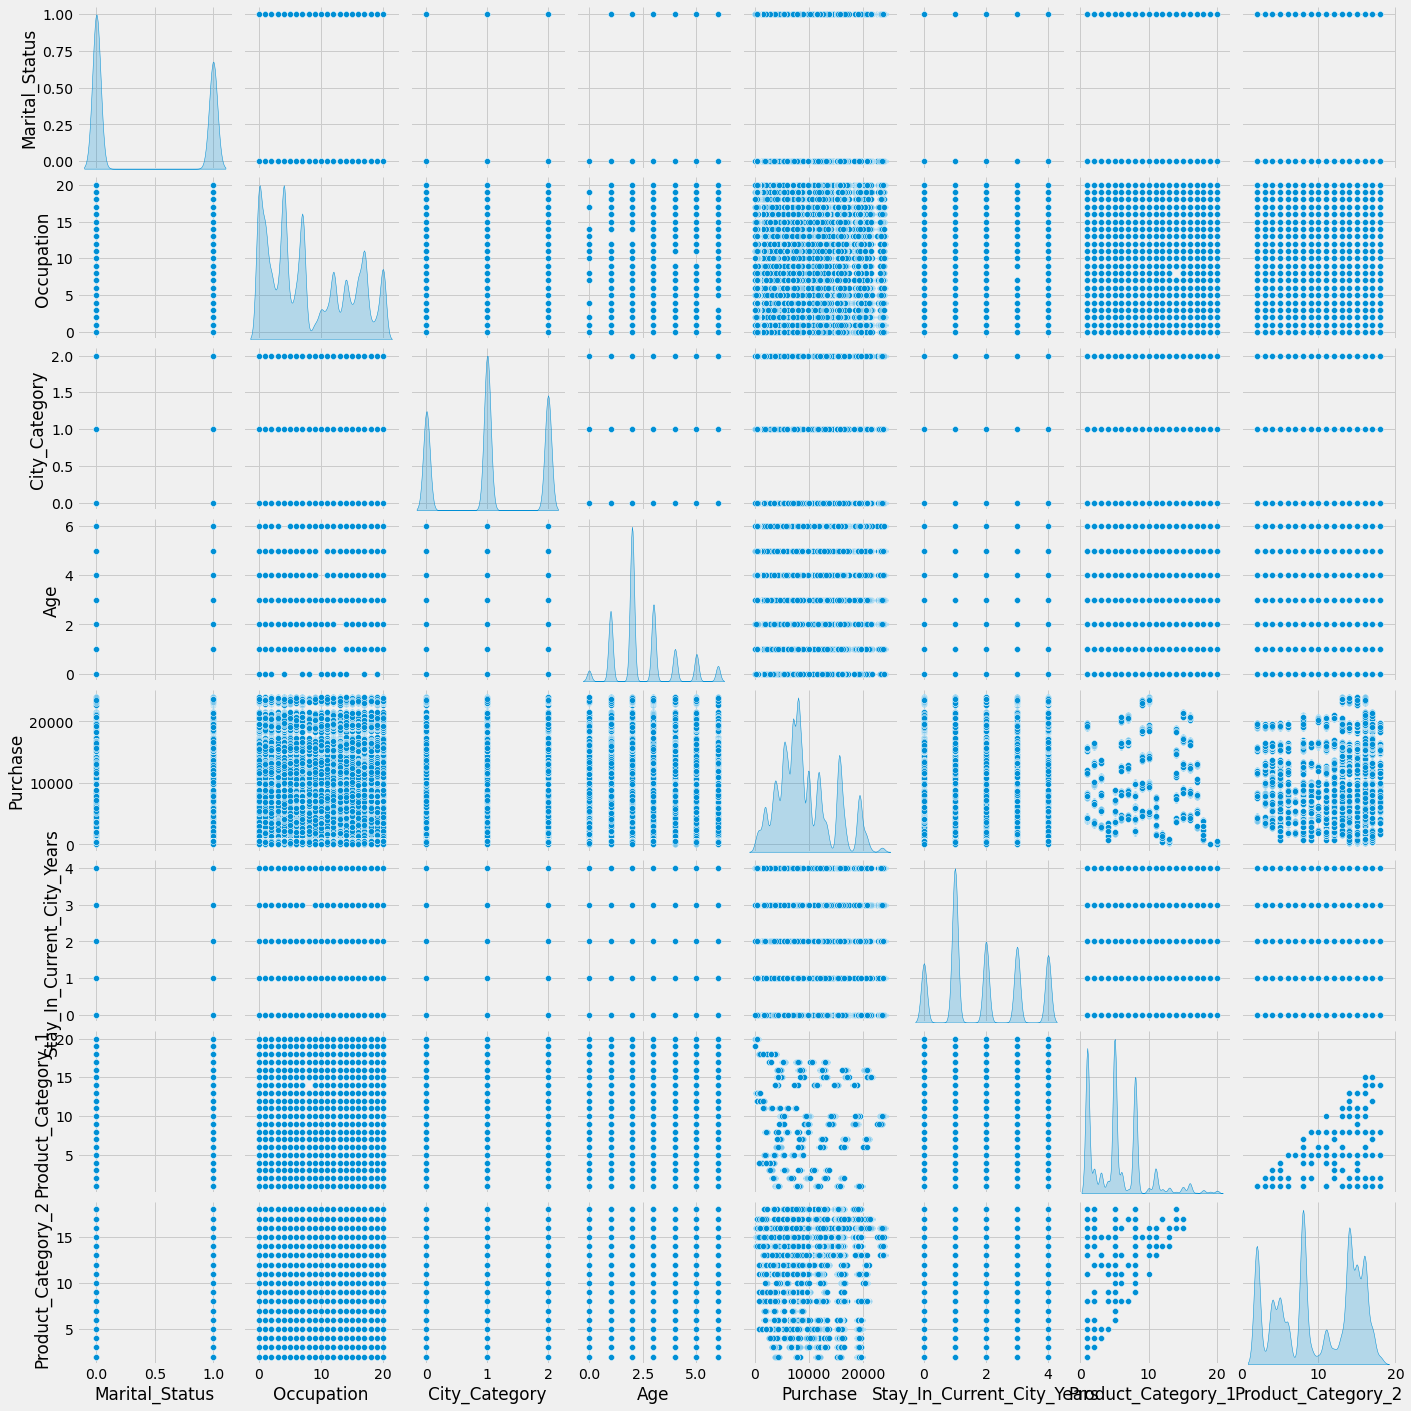

In [33]:
sns.pairplot(df[['Gender', 'Marital_Status', 'Occupation', 'City_Category',  'Age', 'Purchase', 'Stay_In_Current_City_Years', 'Product_Category_1', 'Product_Category_2']], diag_kind='kde')

# Feature Engineering 
Partners must describe the following:
- What feature engineering was performed?
- What features were selected for use in the ML model and why?

Evidence must include a description (in the Whitepaper) of the feature engineering performed (and rationale for the same), what original and engineered features were selected for incorporation as independent predictors in the ML model, and why. Evidence must include code snippets detailing the feature engineering and feature selection steps.

# Preprocessing and the data pipeline
The partner must describe the data preprocessing pipeline, and how this is accomplished via a package/function that is a callable API (that is ultimately accessed by the served, production model).

**Evidence** must include a description (in the Whitepaper) of how data preprocessing is accomplished, along with the code snippet that accomplishes data preprocessing as a callable API.

# Input Split
**This Doesn't use the test File. We will need to change it so it does.**

How do we split the data for a recommendation system.

In [34]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,672,F,0,10,0,2,0,3,NaN,NaN,8370
1,1000001,2376,F,0,10,0,2,0,1,6.0,14.0,15200
2,1000001,852,F,0,10,0,2,0,12,NaN,NaN,1422
3,1000001,828,F,0,10,0,2,0,12,14.0,NaN,1057
4,1000002,2734,M,6,16,2,4,0,8,NaN,NaN,7969


In [35]:
X = df.drop(columns=['User_ID', 'Purchase', "Gender", "Product_Category_1", "Product_Category_2", "Product_Category_3"])
y = df['Purchase']

## TensorFlow Recommenders
Something about tensorflow Recommender etc.

# ML model design(s) and selection
Partners must describe the following:
- Which ML model/algorithm(s) were chosen for demo #2?
- What criteria were used for ML model selection?

Evidence must describe (in the Whitepaper) selection criteria implemented, as well as the specific ML model algorithms that were selected for training and evaluation purposes. Code snippets detailing the model design and selection steps must be enumerated.



In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

def train(model, X, y):
  # Train-test split
  x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
  model.fit(x_train, y_train)

  # predict the results
  pred = model.predict(x_test)

  # Cross validation
  cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5) # 5 folds
  cv_score = np.abs(np.mean(cv_score))

  print('Results')
  print('MSE:', mean_squared_error(y_test, pred))
  print('CV Score:', cv_score)


In [39]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X))

In [40]:
print(normalizer.mean.numpy())

[[1707.466    2.496    8.077    1.043    1.858    0.41 ]]


In [42]:
first = np.array(X[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[672   0  10   0   2   0]]

Normalized: [[-1.02 -1.84  0.29 -1.37  0.11 -0.83]]


In [43]:
purchase = np.array(y['Purchase'])

purchase_normalizer = layers.Normalization(input_shape=[1,], axis=None)
purchase_normalizer.adapt(purchase)

In [ ]:
purchase_model = tf.keras.Sequential([
    purchase_normalizer,
    layers.Dense(units=1)
])

purchase_model.summary()

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
train(model, X, y)
coef = pd.Series(model.coef_, X.columns).sort_values()
coef.plot(kind='bar', title='Model Coefficients')

## Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)

# predict the results
pred = classifier.predict(x_test)

# Cross validation
cv_score = cross_val_score(classifier, X, y, scoring='neg_mean_squared_error', cv=5) # 5 folds
cv_score = np.abs(np.mean(cv_score))

print('Results')
print('MSE:', mean_squared_error(y_test, pred))
print('CV Score:', cv_score)


In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
train(model, X, y)
features = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
features.plot(kind='bar', title='Feature Importance')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
train(model, X, y)
features = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
features.plot(kind='bar', title='Feature Importance')

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_jobs=-1)
train(model, X, y)
features = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
features.plot(kind='bar', title='Feature Importance')

In [ ]:
pred = model.predict(x_test)

In [ ]:
submission = pd.DataFrame()
submission['User_ID'] = x_test['User_ID']
submission['Purchase'] = pred

In [ ]:
submission.to_csv('submission.csv', index=False)

# ML model training and development
Partners must document the use of Cloud AI Platform or Dataproc for ML model training, and describe the following:
- Dataset sampling used for model training (and for dev/test independent datasets) and justification of sampling methods.
- Implementation of model training, including adherence to GCP best practices for distribution, device usage, and monitoring.
- The model evaluation metric that is implemented, and a discussion of why the implemented metric is optimal given the business question/goal being addressed.
- Hyper-parameter tuning and model performance optimization.
- How bias/variance were determined (from the train-dev datasets) and tradeoffs used to influence and optimize ML model architecture?

**It might be best to document the code and what service is used here.**

# ML model evaluation
Partner must describe how the ML model, post-training, and architectural/hyperparameter optimization performs on an independent test dataset.

**Evidence** must include records/data (in the Whitepaper) of how the ML model developed and selected to address the business question performed on an independent test dataset (that reflects the distribution of data that the ML model is expected to encounter in a production environment). In addition, code snippets on model testing need to be enumerated.